In [1]:
import numpy as np
import pandas as pd
from math import isnan, sqrt
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

## Data prep

In [3]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [1, 80],
    'highest_temperature1h': [25, 46],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [1, 200],
    'lowest_diastolic_blood_pressure1h': [1, 200],
    'lowest_systolic_blood_pressure1h': [1, 300],
    'bmi': [10, 70]
}

In [4]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [5]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [6]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [7]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [8]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [9]:
# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [10]:
class CustomImputer:
    """
    Impute mode for each categorical column and pre-defined normal values otherwise.
    """
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in self.c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [11]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
            output[c].fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [12]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [13]:
class CustomScaler:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.scalers = [(c, StandardScaler().fit(X[c].astype(float).values.reshape(-1,1))) for c in self.columns]
        return self

    def transform(self, X):
        output = X.copy()
        for c, s in self.scalers:
            output[c] = s.transform(output[c].astype(float).values.reshape(-1,1))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [14]:
def smr_score(y_true, y_pred):
    return sum(y_true)/sum(y_pred)

In [15]:
# Lists of variable types
target = "hospitalexpireflag"

#pre icu
demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

#lab results
physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols_og = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols_og = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

### Helper Functions To Run The Models

In [32]:
def plot_calib_curve(y_true, y_pred, ax = None, n_bins = 10, with_histogram=False, width=0.1, **kwargs):
    if type(y_true) is list:
        y_true = np.asarray(y_true)
    if type(y_pred) is list:
        y_pred = np.asarray(y_pred)
        
    # Metrics Logit
    if ax is None:
        ax=plt.gca()
        
    # calculate SMR
    smr = smr_score(y_true, y_pred)
    smr_ci = ci(smr_score, y_true, y_pred)
    
    # calculate AUROC
    auc = roc_auc_score(y_true, y_pred)
    auc_ci = ci(roc_auc_score, y_true, y_pred)
    
    # add AUROC to legend
    if 'label' not in kwargs:
        kwargs['label'] = ''
    
    xi = np.linspace(0, 1, n_bins+1)
    
    expected  = np.ones(n_bins)*np.nan
    observed = np.ones(n_bins)*np.nan
    N = np.zeros(n_bins)
    for i in range(len(xi)-1):
        idx = (y_pred > xi[i]) & (y_pred <= xi[i+1])
        if np.any(idx):
            expected[i] = np.sum(y_pred[idx])
            observed[i] = np.sum(y_true[idx])
            N[i] = np.sum(idx)
        
    
    # calibration curve
    p = ax.plot(expected/N, observed/N, **kwargs)
    
    if with_histogram:
        # add transparent histogram
        c = p[0].get_color()
        ax.bar(expected/N, N/np.sum(N), width=width, alpha=0.5, facecolor=c)
        
    print(kwargs['label'] + "\tAUC - {:0.3f} ({:0.3f} - {:0.3f} 95% CI)".format(auc, auc_ci[0], auc_ci[1]))
    print(kwargs['label'] + "\tSMR - {:0.3f} ({:0.3f} - {:0.3f} 95% CI)".format(smr, smr_ci[0], smr_ci[1]))

In [33]:
def columns2block(block):
    if block == 1:
        columns = physiological
    elif block == 2:
        columns = demographic
    elif block == 3:
        columns = physiological + demographic
    elif block == 4:
        columns = physiological + demographic + glasgow
    return columns

In [34]:
def ci(metric, y_true, y_pred, confidence=0.95, samples=2000):
    '''Confidence Interval calculator'''
    
    scores = []
    np.random.RandomState(42)
    for i in range(samples):
        indices = np.random.randint(0, len(y_pred) - 1, len(y_pred))
        scores.append(metric(y_true[indices], y_pred[indices]))
    scores = np.sort(scores)
    
    n = len(scores)
    lower = int( (1 - confidence) / 2 * n )
    upper = int( (1 + confidence) / 2 * n )
    
    return (scores[lower], scores[upper])

In [35]:
def prep_data_and_pipeline(hiae, hmvsc, columns, target, model='lr'):
    # Seperate x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    for c in X_hiae.columns:
        X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
        X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Get unique values for categorical features, after filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]

    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    #Normal values filtered for each block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
    
    
    if model in ('lr','logr'):
        # Model
        logr = LogisticRegression(solver='liblinear', penalty='l1')
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("encoder", CustomLabelEncoder(values)),
            ("ohe", OneHotEncoder(c_cols)),
            ("scaler", CustomScaler(n_cols)),
            ("model", logr)])
    elif model in ('xgb','xbst'):
        # Model
        xbst = XGBClassifier(n_estimators=100, max_depth=2)

        # Create pipeline
        pipe = Pipeline([
            ("lenc", CustomLabelEncoder(values)),
            ("model", xbst)
        ])
    elif model in ('xgbi','xgb_impute'):
        # Model
        xgbi = XGBClassifier(n_estimators=100, max_depth=2)
        
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("lenc", CustomLabelEncoder(values)),
            ("model", xgbi)
        ])
    else:
        raise ValueError('Unrecognized model.')
        
    return X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe

## Logit trained in HIAE data

HIAE	AUC - 0.659 (0.633 - 0.684 95% CI)
HIAE	SMR - 0.996 (0.912 - 1.077 95% CI)
HMVSC	AUC - 0.650 (0.615 - 0.684 95% CI)
HMVSC	SMR - 2.145 (1.942 - 2.351 95% CI)


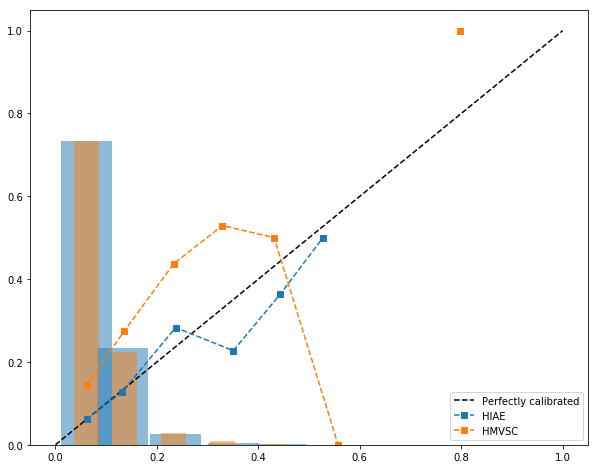

HIAE	AUC - 0.772 (0.752 - 0.792 95% CI)
HIAE	SMR - 0.999 (0.917 - 1.078 95% CI)
HMVSC	AUC - 0.763 (0.735 - 0.791 95% CI)
HMVSC	SMR - 2.324 (2.108 - 2.534 95% CI)


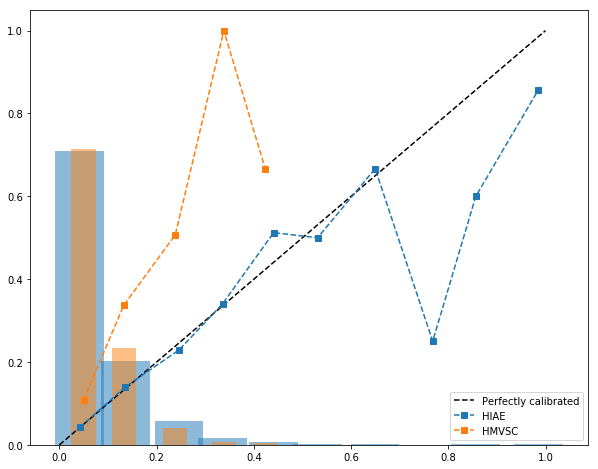

HIAE	AUC - 0.804 (0.784 - 0.822 95% CI)
HIAE	SMR - 0.996 (0.921 - 1.078 95% CI)
HMVSC	AUC - 0.781 (0.754 - 0.808 95% CI)
HMVSC	SMR - 2.191 (1.993 - 2.403 95% CI)


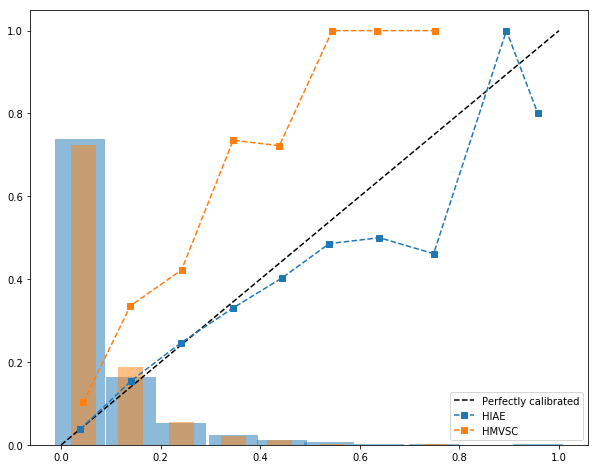

HIAE	AUC - 0.830 (0.813 - 0.846 95% CI)
HIAE	SMR - 0.996 (0.921 - 1.073 95% CI)
HMVSC	AUC - 0.837 (0.811 - 0.861 95% CI)
HMVSC	SMR - 1.951 (1.784 - 2.117 95% CI)


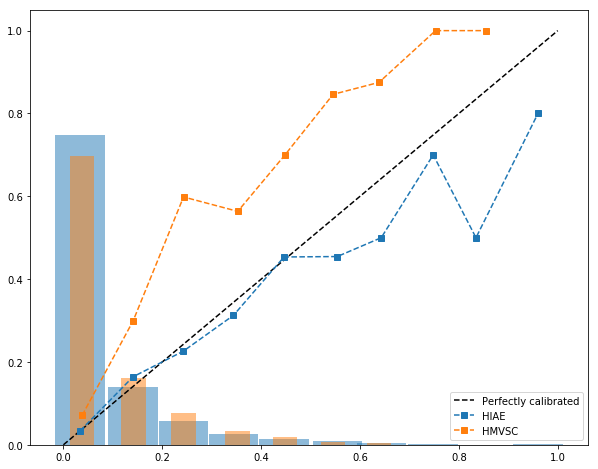

In [36]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='lr')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE data

HIAE	AUC - 0.663 (0.637 - 0.688 95% CI)
HIAE	SMR - 0.999 (0.921 - 1.084 95% CI)
HMVSC	AUC - 0.651 (0.616 - 0.684 95% CI)
HMVSC	SMR - 2.022 (1.824 - 2.233 95% CI)


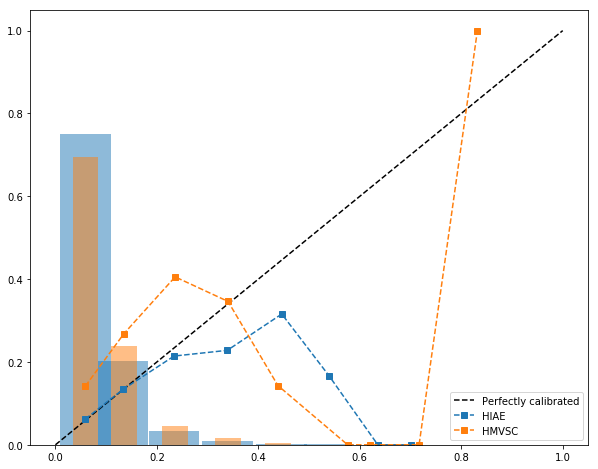

HIAE	AUC - 0.781 (0.762 - 0.802 95% CI)
HIAE	SMR - 1.004 (0.925 - 1.081 95% CI)
HMVSC	AUC - 0.744 (0.712 - 0.773 95% CI)
HMVSC	SMR - 2.567 (2.325 - 2.818 95% CI)


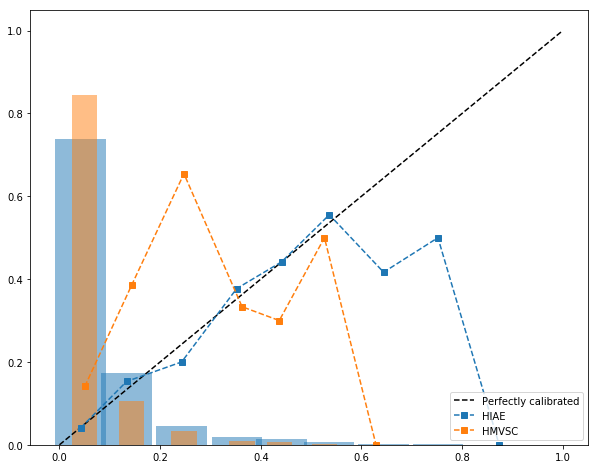

HIAE	AUC - 0.808 (0.790 - 0.827 95% CI)
HIAE	SMR - 1.000 (0.924 - 1.078 95% CI)
HMVSC	AUC - 0.771 (0.742 - 0.799 95% CI)
HMVSC	SMR - 2.461 (2.234 - 2.696 95% CI)


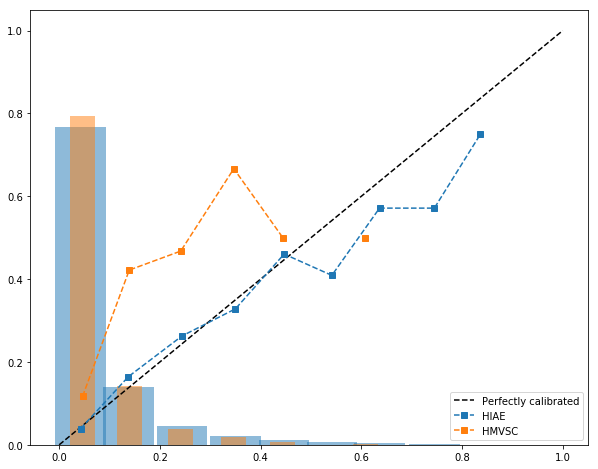

HIAE	AUC - 0.835 (0.818 - 0.851 95% CI)
HIAE	SMR - 1.004 (0.931 - 1.079 95% CI)
HMVSC	AUC - 0.831 (0.805 - 0.854 95% CI)
HMVSC	SMR - 2.169 (1.983 - 2.363 95% CI)


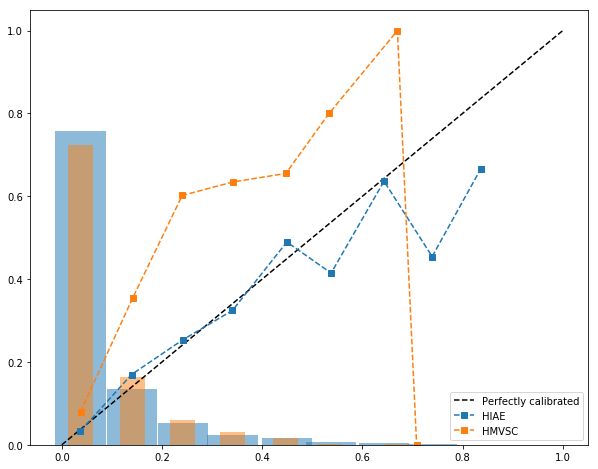

In [37]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgb')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE imputed data

HIAE	AUC - 0.670 (0.646 - 0.695 95% CI)
HIAE	SMR - 1.002 (0.924 - 1.079 95% CI)
HMVSC	AUC - 0.651 (0.616 - 0.685 95% CI)
HMVSC	SMR - 2.064 (1.863 - 2.279 95% CI)


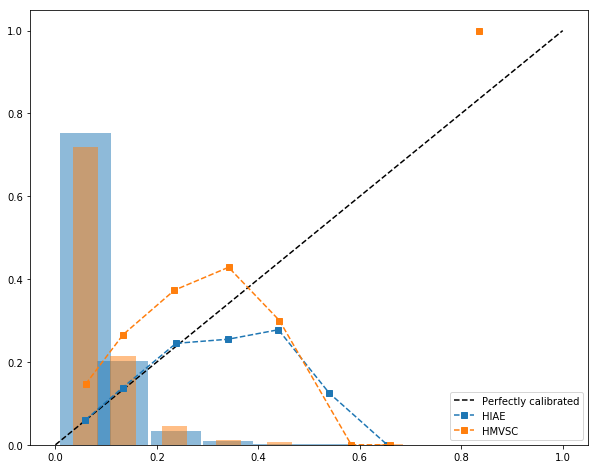

HIAE	AUC - 0.783 (0.762 - 0.802 95% CI)
HIAE	SMR - 1.004 (0.925 - 1.085 95% CI)
HMVSC	AUC - 0.745 (0.715 - 0.774 95% CI)
HMVSC	SMR - 2.539 (2.282 - 2.801 95% CI)


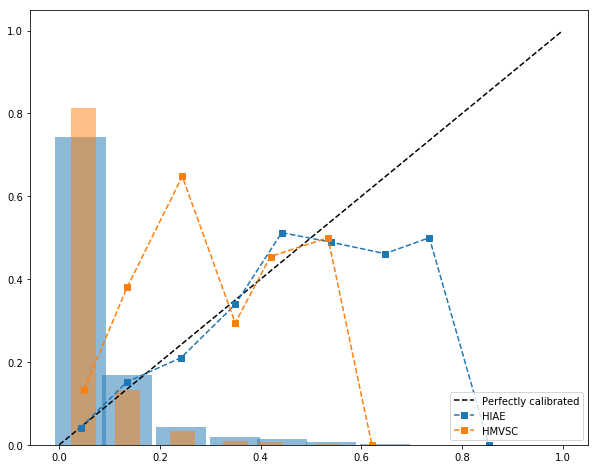

HIAE	AUC - 0.810 (0.791 - 0.828 95% CI)
HIAE	SMR - 1.004 (0.931 - 1.082 95% CI)
HMVSC	AUC - 0.764 (0.735 - 0.792 95% CI)
HMVSC	SMR - 2.478 (2.249 - 2.727 95% CI)


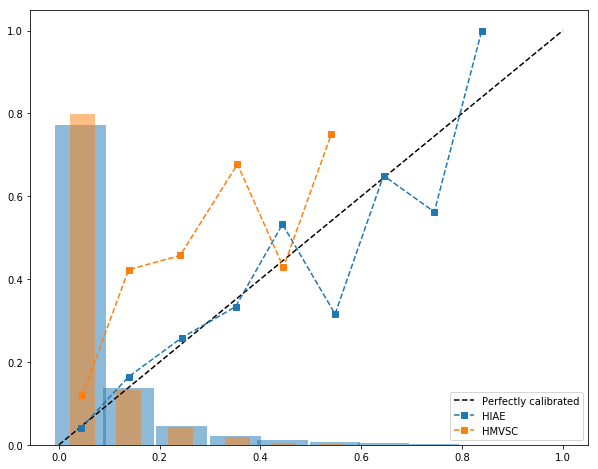

HIAE	AUC - 0.836 (0.819 - 0.852 95% CI)
HIAE	SMR - 1.009 (0.932 - 1.089 95% CI)
HMVSC	AUC - 0.832 (0.807 - 0.857 95% CI)
HMVSC	SMR - 2.290 (2.098 - 2.484 95% CI)


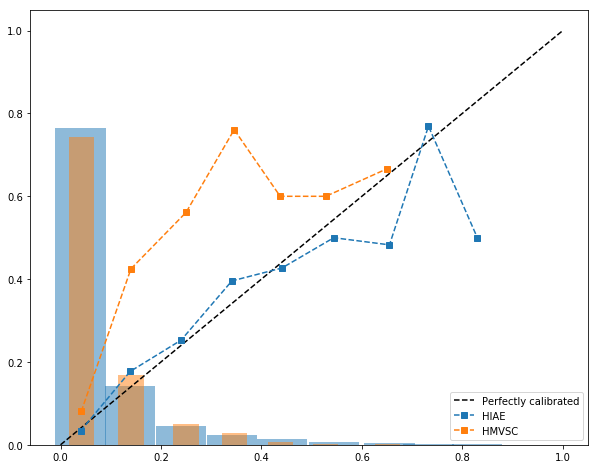

In [38]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgbi')
    
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()